Straightforward translation of https://github.com/rmeinl/apricot-julia/blob/5f130f846f8b7f93bb4429e2b182f0765a61035c/notebooks/python_reimpl.ipynb

See also https://github.com/genkuroki/public/blob/main/0016/apricot/python_reimpl.ipynb

In [1]:
using Seaborn
using ScikitLearn: @sk_import
@sk_import datasets: fetch_covtype
using Random
using StatsBase

In [2]:
digits_data = fetch_covtype()

Dict{Any, Any} with 6 entries:
  "feature_names" => ["Elevation", "Aspect", "Slope", "Horizontal_Distance_To_H…
  "frame"         => nothing
  "target_names"  => ["Cover_Type"]
  "data"          => [2596.0 51.0 … 0.0 0.0; 2590.0 56.0 … 0.0 0.0; … ; 2384.0 …
  "target"        => Int32[5, 5, 2, 2, 5, 2, 5, 5, 5, 5  …  3, 3, 3, 3, 3, 3, 3…
  "DESCR"         => ".. _covtype_dataset:\n\nForest covertypes\n--------------…

In [3]:
X_digits = permutedims(abs.(digits_data["data"]))
summary(X_digits)

"54×581012 Matrix{Float64}"

In [4]:
"""`calculate_gains!(X, gains, current_values, idxs, current_concave_values_sum)` mutates `gains` only"""
function calculate_gains!(X, gains, current_values, idxs, current_concave_values_sum)
    Threads.@threads for i in eachindex(idxs)
        @inbounds idx = idxs[i]
        @inbounds gains[i] = sum(j -> sqrt(current_values[j] + X[j, idx]), axes(X, 1))
    end
    gains .-= current_concave_values_sum
end

@doc calculate_gains!

`calculate_gains!(X, gains, current_values, idxs, current_concave_values_sum)` mutate `gains` only


In [5]:
function fit(X, k; calculate_gains! = calculate_gains!)
    d, n = size(X)

    cost = 0.0

    ranking = Int[]
    total_gains = Float64[]

    current_values = zeros(d)
    current_concave_values_sum = sum(sqrt, current_values)

    idxs = collect(1:n)

    gains = zeros(n)
    while cost < k
        calculate_gains!(X, gains, current_values, idxs, current_concave_values_sum)

        idx = argmax(gains)
        best_idx = idxs[idx]
        curr_cost = 1.0
        
        cost + curr_cost > k && break

        cost += curr_cost
        # Calculate gains
        gain = gains[idx] * curr_cost

        # Select next
        current_values .+= @view X[:, best_idx]
        current_concave_values_sum = sum(sqrt, current_values)

        push!(ranking, best_idx)
        push!(total_gains, gain)

        popat!(idxs, best_idx)
    end
    return ranking, total_gains
end

fit (generic function with 1 method)

In [6]:
k = 1000

1000

In [7]:
@time ranking0, gains0 = fit(X_digits, k; calculate_gains! = calculate_gains!);

 13.629035 seconds (1.10 M allocations: 74.945 MiB, 0.34% gc time, 1.97% compilation time)


In [8]:
@time ranking0, gains0 = fit(X_digits, k; calculate_gains! = calculate_gains!);

 12.383739 seconds (62.84 k allocations: 14.995 MiB)


In [9]:
tic = time()
ranking0, gains0 = fit(X_digits, k; calculate_gains! = calculate_gains!)
toc0 = time() - tic
toc0

12.678999900817871

In [10]:
@time begin
idxs = sample(axes(X_digits, 2), k; replace=false)
X_subset = X_digits[:, idxs]
gains1 = cumsum(X_subset; dims=2)
gains1 = vec(sum(sqrt, gains1; dims=1))
end;

  0.392773 seconds (1.28 M allocations: 77.530 MiB, 99.79% compilation time)


In [11]:
@time begin
idxs = sample(axes(X_digits, 2), k; replace=false)
X_subset = X_digits[:, idxs]
gains1 = cumsum(X_subset; dims=2)
gains1 = vec(sum(sqrt, gains1; dims=1))
end;

  0.000514 seconds (20 allocations: 878.602 KiB)


In [12]:
tic = time()
idxs = sample(axes(X_digits, 2), k; replace=false)
X_subset = X_digits[:, idxs]
gains1 = cumsum(X_subset; dims=2)
gains1 = vec(sum(sqrt, gains1; dims=1))
toc1 = time() - tic
toc1

0.004999876022338867

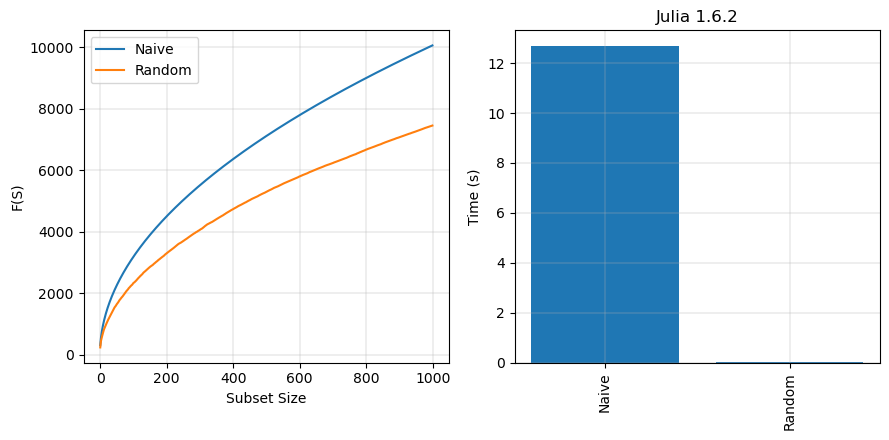

In [13]:
plt.figure(figsize=(9, 4.5))

plt.subplot(121)
plt.plot(cumsum(gains0), label="Naive")
plt.plot(gains1, label="Random")
plt.ylabel("F(S)")
plt.xlabel("Subset Size")
plt.legend()
plt.grid(lw=0.3)

plt.subplot(122)
plt.bar(1:2, [toc0,  toc1])
plt.ylabel("Time (s)")
plt.xticks(1:2, ["Naive", "Random"], rotation=90)
plt.grid(lw=0.3)
plt.title("Julia 1.6.2")

plt.tight_layout()
#plt.show()